# DIWASP-Python: End-to-End Wave Analysis Demonstration

This notebook demonstrates the complete workflow for directional wave spectrum analysis using DIWASP-Python.

We'll cover:
1. Creating synthetic wave data with varying conditions
2. Analyzing data with different sensor configurations
3. Comparing different estimation methods
4. Visualizing results

In [1]:
# Create an idealized JONSWAP spectrum

from diwasp import makespec

ideal_spec = makespec(
    freq_range=(0.05, 0.1, 0.5),  # (low_freq, peak_freq, high_freq) in Hz
    theta=45.0,                    # Peak direction (from NE)
    spread=75.0,                   # Directional spreading parameter
    hsig=2.0,                      # Significant wave height
    depth=20.0,                    # Water depth
    n_freqs=50,                    # Number of frequency bins
    n_dirs=180,                    # Number of direction bins
)


print(f"Ideal spectrum created:")
print(f"  Hsig: {ideal_spec.hs:.2f} m")
print(f"  Tp: {ideal_spec.tp:.2f} s")
print(f"  Peak direction: {ideal_spec.dp:.1f} deg")

Ideal spectrum created:
  Hsig: 2.00 m
  Tp: 9.51 s
  Peak direction: 44.0 deg


In [2]:
# Generate synthetic sensor data (PUV configuration)
from diwasp import InstrumentData, SensorType, make_wave_data

fs = 2.0  # 2 Hz sampling
duration = 3600  # 1 hour
n_samples = int(duration * fs)

# Sensor layout: pressure at 0.5m, velocities at 1.0m above seabed
layout = np.array([
    [0, 0, 0],      # x positions
    [0, 0, 0],      # y positions  
    [0.5, 1.0, 1.0] # z positions
])

# Create InstrumentData object
instrument = InstrumentData(
    data=np.zeros((n_samples, 3)),  # Placeholder, will be filled by make_wave_data
    layout=layout,
    datatypes=[SensorType.PRES, SensorType.VELX, SensorType.VELY],
    depth=20.0,
    fs=fs
)

# Generate wave data
data = make_wave_data(
    spectrum=ideal_spec,
    instrument_data=instrument,
    n_samples=n_samples,
)

print(f"Generated {data.shape[0]} samples ({duration}s at {fs}Hz)")
print(f"Sensors: pressure, u-velocity, v-velocity")

Generated 7200 samples (3600s at 2.0Hz)
Sensors: pressure, u-velocity, v-velocity


## 1. Steady Sea State Analysis

First, let's analyze a steady sea state with a single dominant wave direction.

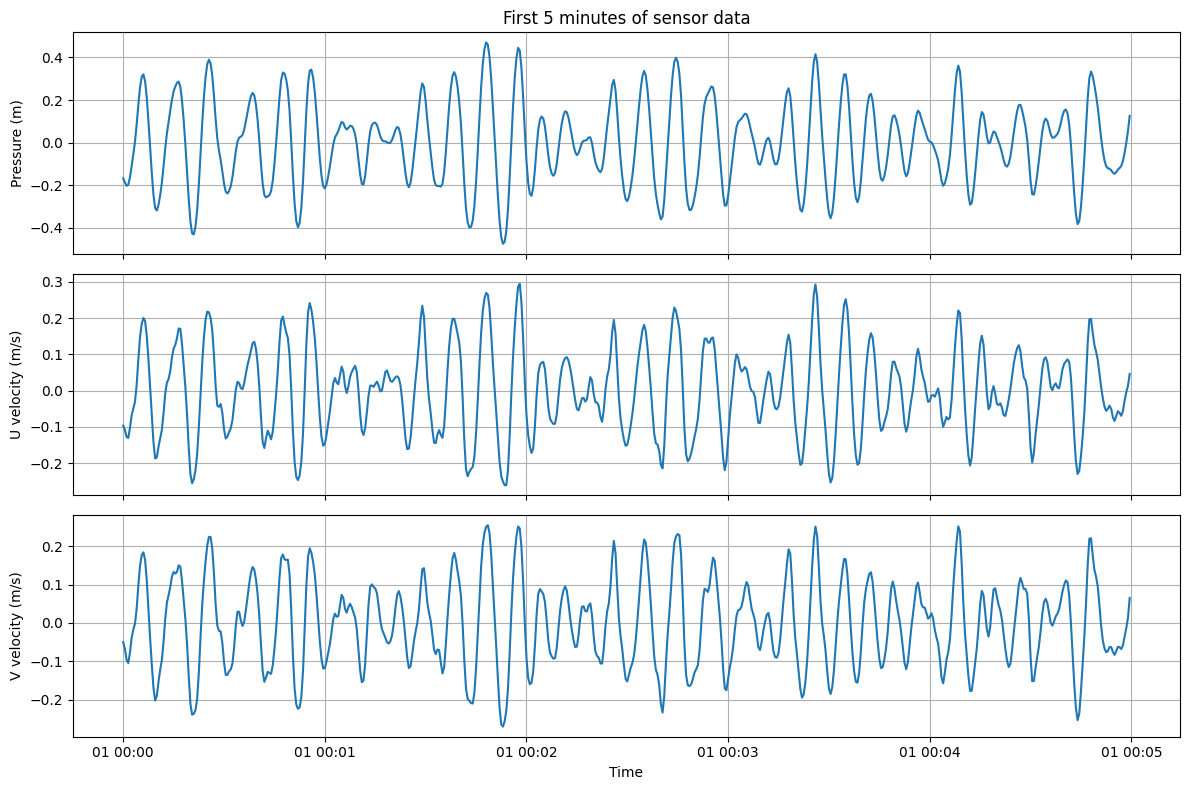

In [3]:
# Create DataFrame for analysis

import pandas as pd
import matplotlib.pyplot as plt

n_samples = int(duration * fs)
time = pd.date_range('2024-01-01', periods=n_samples, freq=f'{int(1000/fs)}ms')

df = pd.DataFrame({
    'pressure': data[:, 0],
    'u_velocity': data[:, 1],
    'v_velocity': data[:, 2],
}, index=time)

# Quick look at the data
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axes[0].plot(df.index[:600], df['pressure'][:600])
axes[0].set_ylabel('Pressure (m)')
axes[0].set_title('First 5 minutes of sensor data')
axes[0].grid(True)

axes[1].plot(df.index[:600], df['u_velocity'][:600])
axes[1].set_ylabel('U velocity (m/s)')
axes[1].grid(True)

axes[2].plot(df.index[:600], df['v_velocity'][:600])
axes[2].set_ylabel('V velocity (m/s)')
axes[2].set_xlabel('Time')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [4]:
# Run DIWASP analysis with 30-minute windows, 15-minute overlap
from diwasp import diwasp

result = diwasp(
    df,
    sensor_mapping={'pressure': 'pres', 'u_velocity': 'velx', 'v_velocity': 'vely'},
    window_length=1800,      # 30 minutes
    window_overlap=900,       # 15 minutes overlap
    depth=20.0,
    z={'pressure': 0.5, 'u_velocity': 1.0, 'v_velocity': 1.0},
    method='emlm',
    verbose=1,
)

print(f"\nAnalysis complete!")
print(f"Output shape: {result['efth'].shape}")
print(f"Number of time windows: {len(result.time)}")

DIWASP Analysis
  Method: EMLM
  Sampling frequency: 2.00 Hz
  Window length: 1800.0 s
  Window overlap: 900.0 s
  Depth: 20.0 m
  Sensors: 3
  Number of windows: 3

Analysis complete. Output shape: (3, 123, 180)

Analysis complete!
Output shape: (3, 123, 180)
Number of time windows: 3


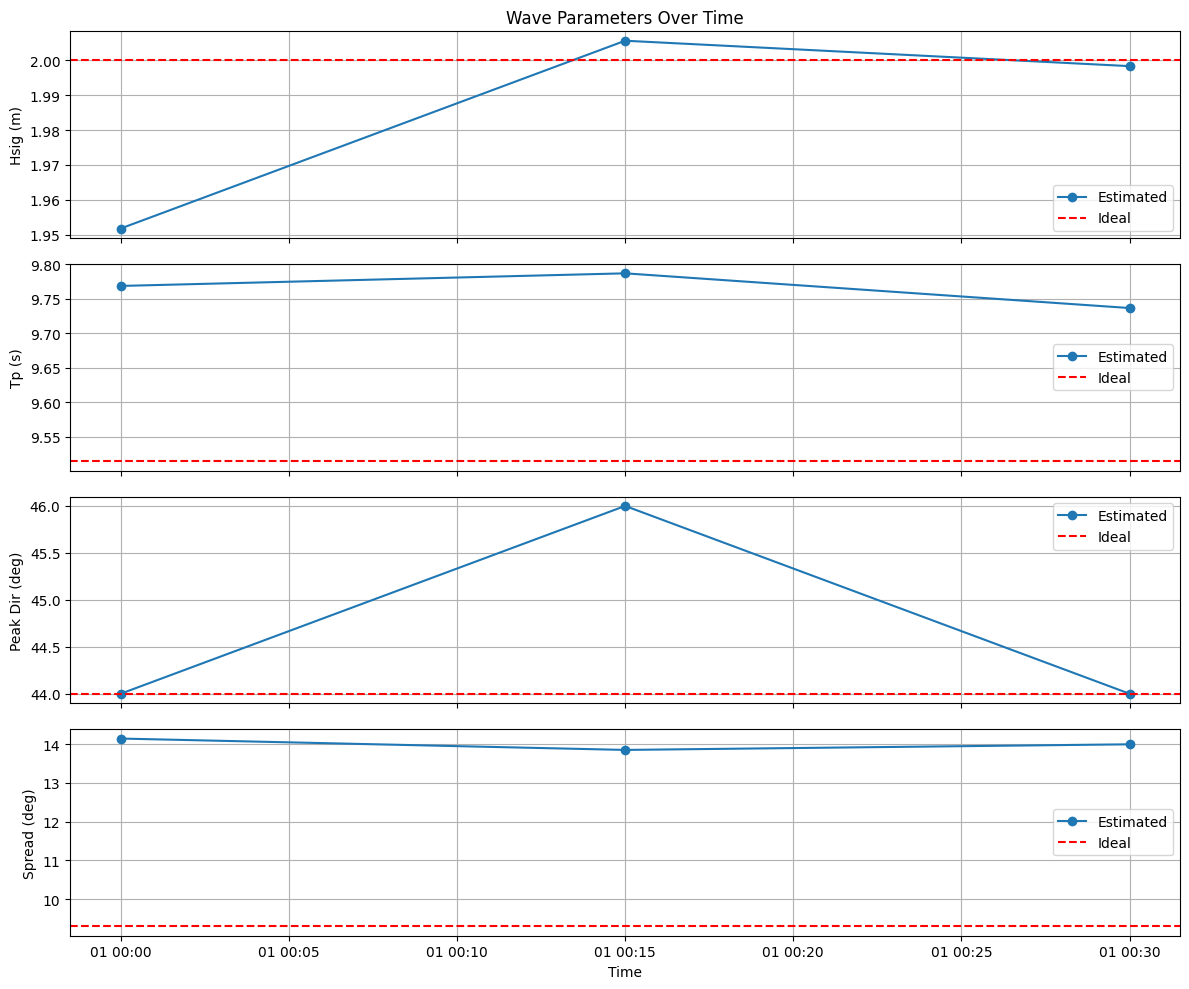


Summary Statistics:
  Hsig: 1.99 ± 0.02 m (ideal: 2.00 m)
  Tp: 9.76 ± 0.02 s (ideal: 9.51 s)
  Peak Dir: 44.7 ± 0.9 deg (ideal: 44.0 deg)


In [5]:
import wavespectra
# Plot time series of wave parameters
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axes[0].plot(result.time, result.spec.hs().values, 'o-', label='Estimated')
axes[0].axhline(ideal_spec.hs, color='r', linestyle='--', label='Ideal')
axes[0].set_ylabel('Hsig (m)')
axes[0].set_title('Wave Parameters Over Time')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(result.time, result.spec.tp().values, 'o-', label='Estimated')
axes[1].axhline(ideal_spec.tp, color='r', linestyle='--', label='Ideal')
axes[1].set_ylabel('Tp (s)')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(result.time, result.spec.dp().values, 'o-', label='Estimated')
axes[2].axhline(ideal_spec.dp, color='r', linestyle='--', label='Ideal')
axes[2].set_ylabel('Peak Dir (deg)')
axes[2].legend()
axes[2].grid(True)

axes[3].plot(result.time, result.spec.dspr().values, 'o-', label='Estimated')
axes[3].axhline(ideal_spec.dspr, color='r', linestyle='--', label='Ideal')
axes[3].set_ylabel('Spread (deg)')
axes[3].set_xlabel('Time')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"  Hsig: {result.spec.hs().mean().values:.2f} ± {result.spec.hs().std().values:.2f} m (ideal: {ideal_spec.hs:.2f} m)")
print(f"  Tp: {result.spec.tp().mean().values:.2f} ± {result.spec.tp().std().values:.2f} s (ideal: {ideal_spec.tp:.2f} s)")
print(f"  Peak Dir: {result.spec.dp().mean().values:.1f} ± {result.spec.dp().std().values:.1f} deg (ideal: {ideal_spec.dp:.1f} deg)")

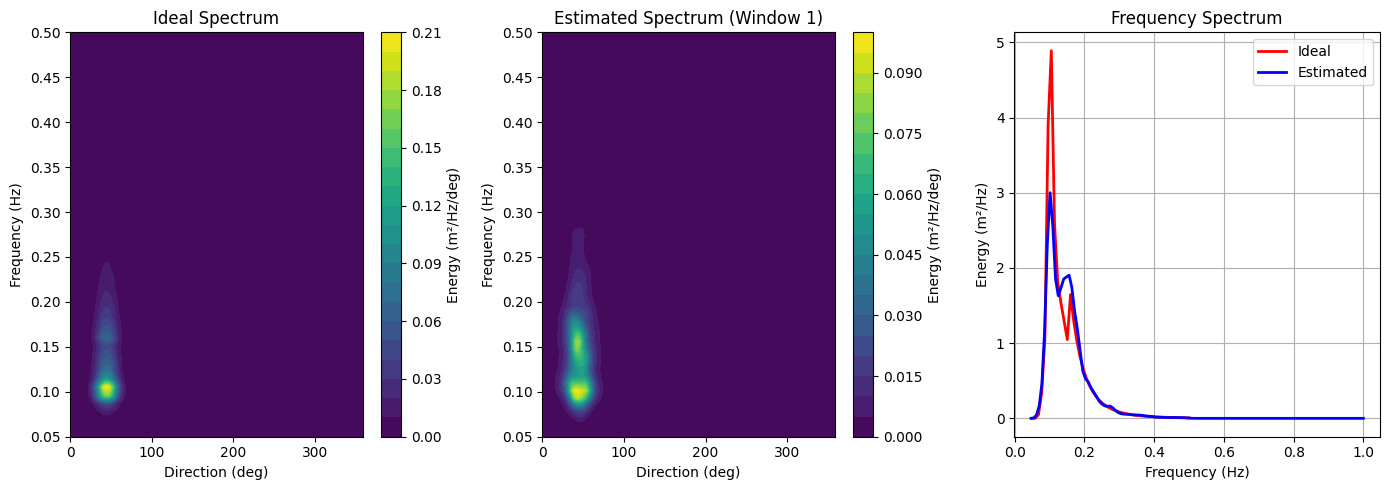

In [6]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Plot 2D spectrum for first window
fig = plt.figure(figsize=(14, 5))
gs = GridSpec(1, 3, figure=fig)

# Ideal spectrum
ax1 = fig.add_subplot(gs[0, 0])
c1 = ax1.contourf(ideal_spec.dirs, ideal_spec.freqs, ideal_spec.S, levels=20, cmap='viridis')
ax1.set_xlabel('Direction (deg)')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_title('Ideal Spectrum')
plt.colorbar(c1, ax=ax1, label='Energy (m²/Hz/deg)')

# Estimated spectrum (first window)
ax2 = fig.add_subplot(gs[0, 1])
c2 = ax2.contourf(result.dir, result.freq, result.efth[0], levels=20, cmap='viridis')
ax2.set_xlabel('Direction (deg)')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_title('Estimated Spectrum (Window 1)')
ax2.set_ylim(ideal_spec.freqs[0], ideal_spec.freqs[-1])
plt.colorbar(c2, ax=ax2, label='Energy (m²/Hz/deg)')

# Frequency spectra comparison
ax3 = fig.add_subplot(gs[0, 2])
ideal_freq_spec = ideal_spec.S.sum(axis=1) * ideal_spec.ddir
est_freq_spec = np.sum(result.efth[0], axis=1) * (result.dir[1] - result.dir[0]).values
ax3.plot(ideal_spec.freqs, ideal_freq_spec, 'r-', linewidth=2, label='Ideal')
ax3.plot(result.freq, est_freq_spec, 'b-', linewidth=2, label='Estimated')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Energy (m²/Hz)')
ax3.set_title('Frequency Spectrum')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

## 2. Varying Sea State Analysis

Now let's simulate a changing sea state with varying wave height, period, and direction.

In [7]:
# Create time-varying wave conditions
duration_per_segment = 1800  # 30 minutes per segment
segments = [
    {'hsig': 1.5, 'tp': 8, 'dir': 30, 'label': 'Calm'},
    {'hsig': 2.0, 'tp': 10, 'dir': 45, 'label': 'Building'},
    {'hsig': 2.5, 'tp': 12, 'dir': 60, 'label': 'Peak'},
    {'hsig': 2.0, 'tp': 10, 'dir': 45, 'label': 'Declining'},
]

all_data = []
segment_times = []

for i, seg in enumerate(segments):
    # Create spectrum for this segment
    fp_target = 1.0 / seg['tp']
    spec = makespec(
        freq_range=(0.05, fp_target, 0.5),
        theta=seg['dir'],
        spread=75.0,
        hsig=seg['hsig'],
        depth=20.0,
        n_freqs=50,
        n_dirs=180,
    )
    
    # Create instrument for this segment
    n_seg_samples = int(duration_per_segment * fs)
    instrument_seg = InstrumentData(
        data=np.zeros((n_seg_samples, 3)),
        layout=layout,
        datatypes=[SensorType.PRES, SensorType.VELX, SensorType.VELY],
        depth=20.0,
        fs=fs
    )
    
    # Generate data
    segment_data = make_wave_data(
        spectrum=spec,
        instrument_data=instrument_seg,
        n_samples=n_seg_samples,
    )
    
    all_data.append(segment_data)
    segment_times.append((i * duration_per_segment, (i + 1) * duration_per_segment))
    
    print(f"Segment {i+1} ({seg['label']}): Hsig={seg['hsig']}m, Tp={seg['tp']}s, Dir={seg['dir']}°")

# Concatenate all segments
data_varying = np.vstack(all_data)
total_duration = len(segments) * duration_per_segment
n_samples_varying = int(total_duration * fs)

time_varying = pd.date_range('2024-01-01', periods=n_samples_varying, freq=f'{int(1000/fs)}ms')
df_varying = pd.DataFrame({
    'p': data_varying[:, 0],
    'u': data_varying[:, 1],
    'v': data_varying[:, 2],
}, index=time_varying)

Segment 1 (Calm): Hsig=1.5m, Tp=8s, Dir=30°
Segment 2 (Building): Hsig=2.0m, Tp=10s, Dir=45°
Segment 3 (Peak): Hsig=2.5m, Tp=12s, Dir=60°
Segment 4 (Declining): Hsig=2.0m, Tp=10s, Dir=45°


In [8]:
# Create time-varying wave conditions
duration_per_segment = 1800  # 30 minutes per segment
segments = [
    {'hsig': 1.5, 'tp': 8, 'dir': 30, 'label': 'Calm'},
    {'hsig': 2.0, 'tp': 10, 'dir': 45, 'label': 'Building'},
    {'hsig': 2.5, 'tp': 12, 'dir': 60, 'label': 'Peak'},
    {'hsig': 2.0, 'tp': 10, 'dir': 45, 'label': 'Declining'},
]

all_data = []
segment_times = []
segment_dspr = []

for i, seg in enumerate(segments):
    fp_target = 1 / seg['tp']
    # Create spectrum for this segmentspec = makespec(
    spec = makespec(
        freq_range=(0.05, fp_target, 0.5),
        theta=seg['dir'],
        spread=50.0,
        hsig=seg['hsig'],
        depth=20.0,
        n_freqs=50,
        n_dirs=180,
    )
    
    #Generate data
    segment_data = make_wave_data(
        spectrum=spec,
        instrument_data=instrument_seg,
        n_samples=n_seg_samples,
    )
    
    all_data.append(segment_data)
    segment_times.append((i * duration_per_segment, (i + 1) * duration_per_segment))
    segment_dspr.append(spec.dspr)
    
    print(f"Segment {i+1} ({seg['label']}): Hsig={seg['hsig']}m, Tp={seg['tp']}s, Dir={seg['dir']}°, Dspr={spec.dspr:.2f}")

# Concatenate all segments
data_varying = np.vstack(all_data)
total_duration = len(segments) * duration_per_segment
n_samples = int(total_duration * fs)

time_varying = pd.date_range('2024-01-01', periods=n_samples, freq=f'{int(1000/fs)}ms')
df_varying = pd.DataFrame({
    'p': data_varying[:, 0],
    'u': data_varying[:, 1],
    'v': data_varying[:, 2],
}, index=time_varying)

ideal_varying=pd.DataFrame(segments, index=pd.date_range('2024-01-01', periods=4, freq='30min'))
ideal_varying['dspr'] = segment_dspr


Segment 1 (Calm): Hsig=1.5m, Tp=8s, Dir=30°, Dspr=11.35
Segment 2 (Building): Hsig=2.0m, Tp=10s, Dir=45°, Dspr=11.35
Segment 3 (Peak): Hsig=2.5m, Tp=12s, Dir=60°, Dspr=11.35
Segment 4 (Declining): Hsig=2.0m, Tp=10s, Dir=45°, Dspr=11.35


In [14]:
# Analyze varying sea state
result = diwasp(
    df_varying,
    sensor_mapping={'p': 'pres', 'u': 'velx', 'v': 'vely'},
    window_length=900,   # 15 minutes
    window_overlap=450,  # 7.5 minutes overlap
    depth=20.0,
    z={'p': 0.5, 'u': 1.0, 'v': 1.0},
    method='emlm',
    verbose=1,
)

DIWASP Analysis
  Method: EMLM
  Sampling frequency: 2.00 Hz
  Window length: 900.0 s
  Window overlap: 450.0 s
  Depth: 20.0 m
  Sensors: 3
  Number of windows: 15

Analysis complete. Output shape: (15, 123, 180)


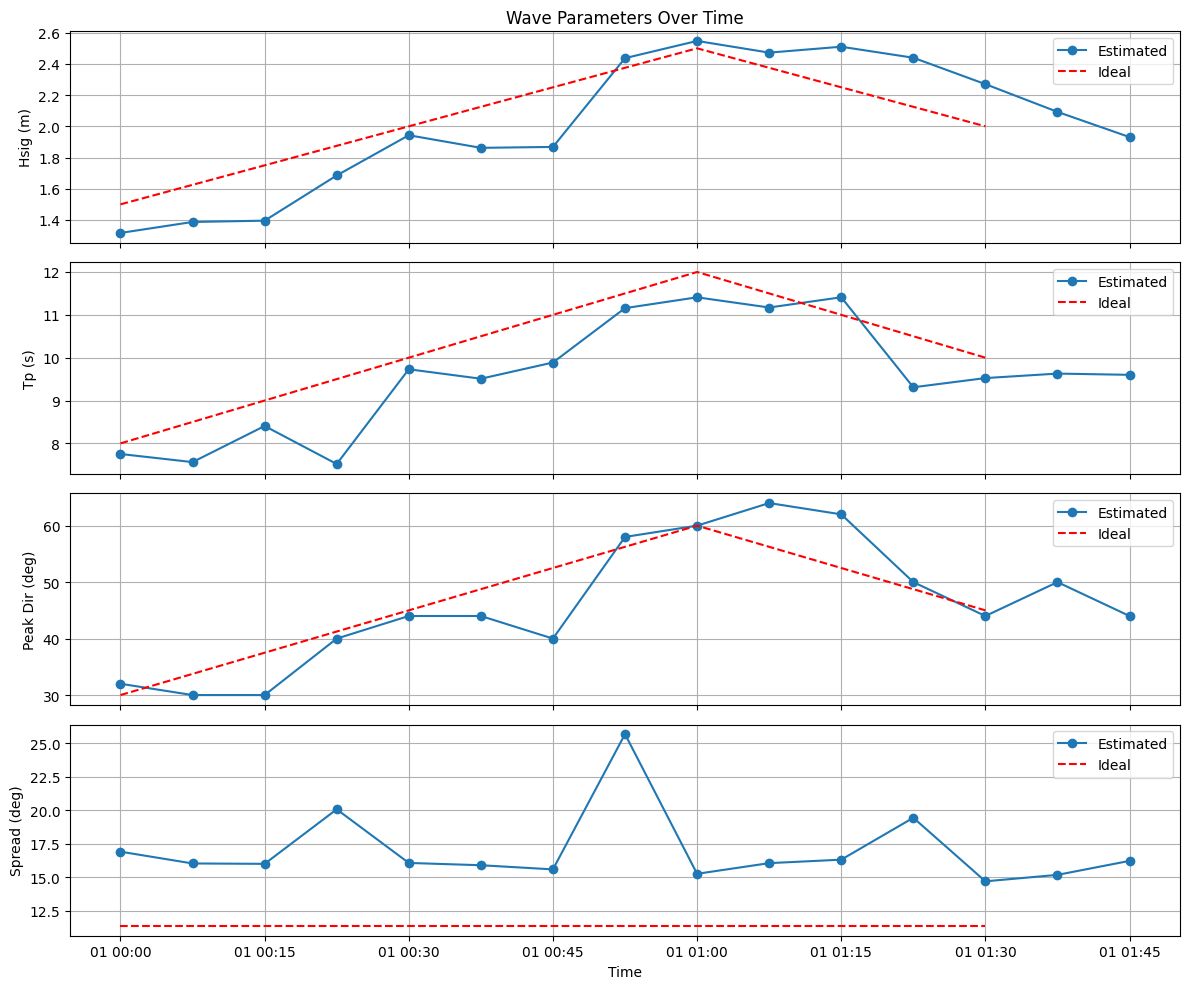

In [15]:
# Plot time series of wave parameters
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axes[0].plot(result.time, result.spec.hs().values, 'o-', label='Estimated')
axes[0].plot(ideal_varying.index, ideal_varying.hsig, color='r', linestyle='--', label='Ideal')
axes[0].set_ylabel('Hsig (m)')
axes[0].set_title('Wave Parameters Over Time')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(result.time, result.spec.tp().values, 'o-', label='Estimated')
axes[1].plot(ideal_varying.index, ideal_varying.tp, color='r', linestyle='--', label='Ideal')
axes[1].set_ylabel('Tp (s)')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(result.time, result.spec.dp().values, 'o-', label='Estimated')
axes[2].plot(ideal_varying.index, ideal_varying.dir, color='r', linestyle='--', label='Ideal')
axes[2].set_ylabel('Peak Dir (deg)')
axes[2].legend()
axes[2].grid(True)

axes[3].plot(result.time, result.spec.dspr().values, 'o-', label='Estimated')
axes[3].plot(ideal_varying.index, ideal_varying.dspr, color='r', linestyle='--', label='Ideal')
axes[3].set_ylabel('Spread (deg)')
axes[3].set_xlabel('Time')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()


## 3. Comparison of Estimation Methods

Let's compare different estimation methods on the same data.

In [11]:
# Create test data
test_spec = makespec(
    freq_range=(0.05, 0.125, 0.5),  # 8 second waves
    theta=90.0,    # From East
    spread=50.0,
    hsig=2.0,
    depth=20.0,
    n_freqs=50,
    n_dirs=180,
)

# Calculate statistics from test spectru

n_test_samples = int(1800 * 2.0)
instrument_test = InstrumentData(
    data=np.zeros((n_test_samples, 3)),
    layout=layout,
    datatypes=[SensorType.PRES, SensorType.VELX, SensorType.VELY],
    depth=20.0,
    fs=2.0
)

test_data = make_wave_data(
    spectrum=test_spec,
    instrument_data=instrument_test,
    n_samples=n_test_samples,
)

instrument_test.data = test_data

time_test = pd.date_range('2024-01-01', periods=test_data.shape[0], freq='500ms')
df_test = pd.DataFrame({
    'p': test_data[:, 0],
    'u': test_data[:, 1],
    'v': test_data[:, 2],
}, index=time_test)

print(f"Test spectrum: Hsig={test_spec.hs:.2f}m, Tp={test_spec.tp:.1f}s, Dir={test_spec.dp:.0f}°")

Test spectrum: Hsig=2.00m, Tp=8.1s, Dir=90°


In [12]:
# Compare methods - Grid layout with original spectrum
from diwasp import dirspec
from diwasp.types import EstimationMethod, EstimationParameters

methods = ['dftm', 'emlm', 'imlm', 'emep', 'bdm']
results_methods = {}

for method_name in methods:
    method_enum = EstimationMethod(method_name.upper())
    est_params = EstimationParameters(method=method_enum)
    print(f"Estimating {method_name}...")
    spectrum = dirspec(instrument_test, estimation_params=est_params, verbose=0)
    results_methods[method_name] = spectrum


Estimating dftm...
Estimating emlm...
Estimating imlm...
Estimating emep...
Estimating bdm...


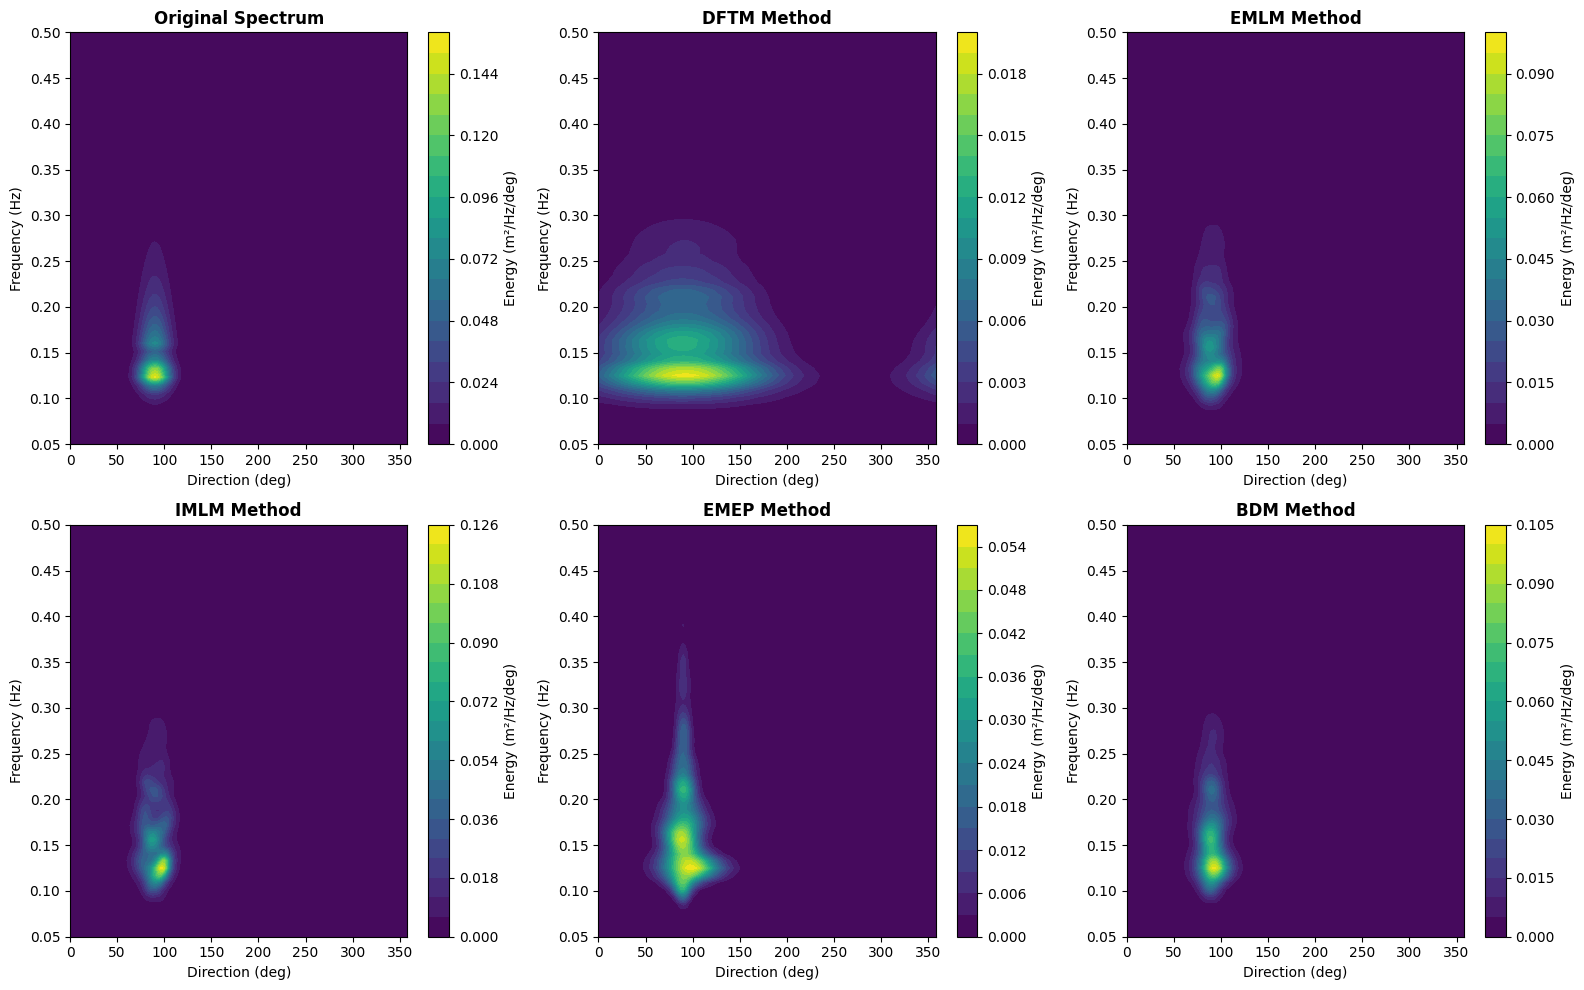


Method       Hsig (m)     Tp (s)       Peak Dir (°)    Spread (°)      Error Hsig (%) 
ORIGINAL     2.00         8.10         90.0            11.3            -              
--------------------------------------------------------------------------------
DFTM         1.87         8.00         92.0            50.4            6.3            
EMLM         1.87         8.00         96.0            16.6            6.3            
IMLM         1.87         8.00         98.0            12.3            6.3            
EMEP         1.87         8.00         98.0            16.6            6.3            
BDM          1.87         8.00         92.0            12.0            6.3            


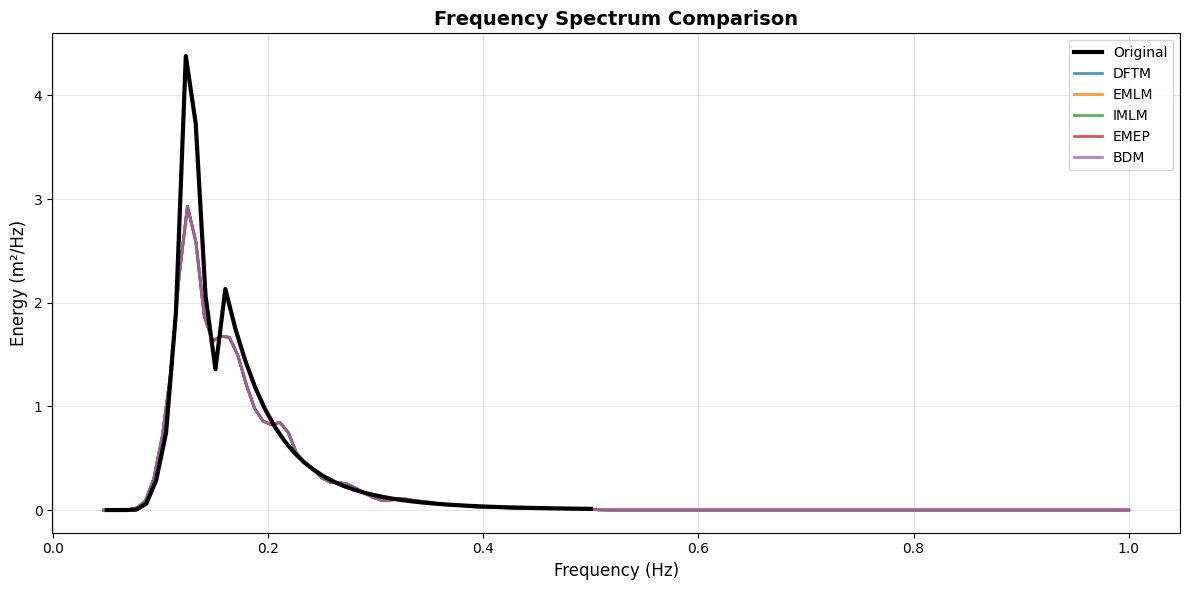

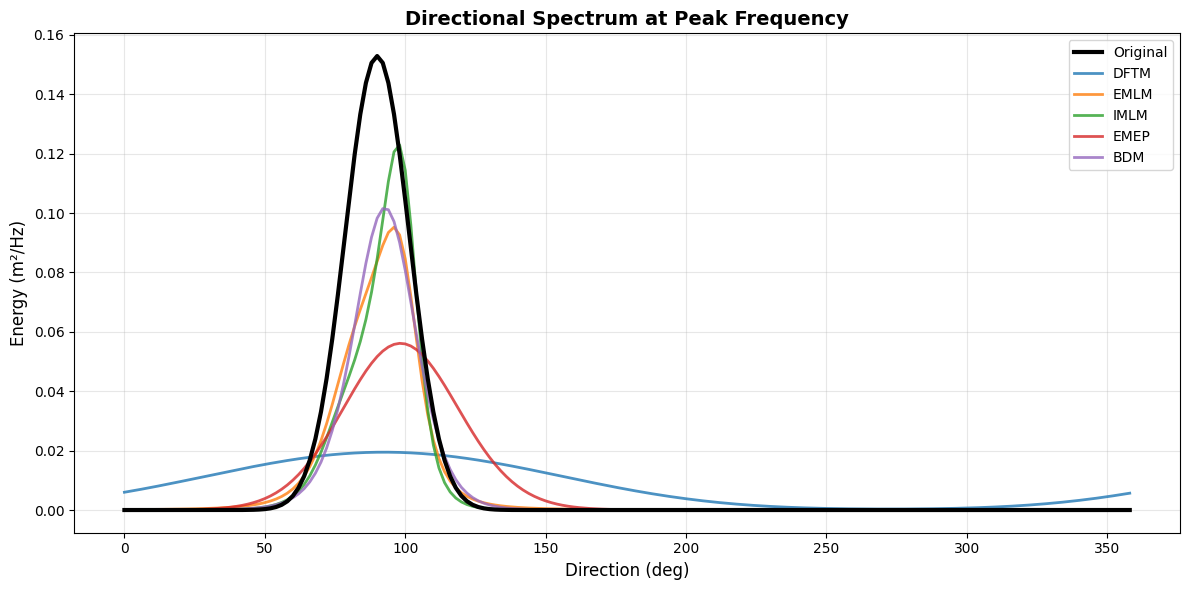

In [13]:


fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Plot ideal spectrum in first panel
c0 = axes[0].contourf(test_spec.dirs, test_spec.freqs, test_spec.S, levels=20, cmap='viridis')
axes[0].set_xlabel('Direction (deg)', fontsize=10)
axes[0].set_ylabel('Frequency (Hz)', fontsize=10)
axes[0].set_title('Original Spectrum', fontweight='bold', fontsize=12)
plt.colorbar(c0, ax=axes[0], label='Energy (m²/Hz/deg)')

# Plot each method
for i, method in enumerate(methods, start=1):
    spectrum = results_methods[method]
    c = axes[i].contourf(spectrum.dirs, spectrum.freqs, spectrum.S, levels=20, cmap='viridis')
    axes[i].set_xlabel('Direction (deg)', fontsize=10)
    axes[i].set_ylabel('Frequency (Hz)', fontsize=10)
    
    axes[i].set_ylim(test_spec.freqs[0], test_spec.freqs[-1])
    axes[i].set_title(f'{method.upper()} Method', fontweight='bold', fontsize=12)
    plt.colorbar(c, ax=axes[i], label='Energy (m²/Hz/deg)')

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*80)
print(f"{'Method':<12} {'Hsig (m)':<12} {'Tp (s)':<12} {'Peak Dir (°)':<15} {'Spread (°)':<15} {'Error Hsig (%)':<15}")
print("="*80)
print(f"{'ORIGINAL':<12} {test_spec.hs:<12.2f} {test_spec.tp:<12.2f} {test_spec.dp:<15.1f} {test_spec.dspr:<15.1f} {'-':<15}")
print("-"*80)

for method in methods:
    spectrum = results_methods[method]

    hsig_err = abs(spectrum.hs- test_spec.hs) / test_spec.hs * 100
    print(f"{method.upper():<12} {spectrum.hs:<12.2f} {spectrum.tp:<12.2f} "
          f"{spectrum.dp:<15.1f} {spectrum.dspr:<15.1f} {hsig_err:<15.1f}")
print("="*80)

# Additional comparison: Frequency spectra
fig2, ax = plt.subplots(1, 1, figsize=(12, 6))

# Original frequency spectrum
original_freq_spec = test_spec.S.sum(axis=1) * (test_spec.dirs[1] - test_spec.dirs[0])
ax.plot(test_spec.freqs, original_freq_spec, 'k-', linewidth=3, label='Original', zorder=10)

# Each method's frequency spectrum
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i, method in enumerate(methods):
    spectrum = results_methods[method]
    freq_spec = spectrum.S.sum(axis=1) * (spectrum.dirs[1] - spectrum.dirs[0])
    ax.plot(spectrum.freqs, freq_spec, '-', linewidth=2, label=method.upper(), 
            color=colors[i], alpha=0.8)

ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Energy (m²/Hz)', fontsize=12)
ax.set_title('Frequency Spectrum Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot comparison of directional spectrum at peak frequeny foreach method
fig3, ax = plt.subplots(1, 1, figsize=(12, 6))
ifp = np.argmax(original_freq_spec)
ax.plot(test_spec.dirs, test_spec.S[ifp], 'k-', linewidth=3, label='Original', zorder=10)

for i, method in enumerate(methods):
    spectrum = results_methods[method]
    ifp = np.argmax(freq_spec)
    dir_spec = spectrum.S[ifp]
    ax.plot(spectrum.dirs, dir_spec, '-', linewidth=2, label=method.upper(), 
            color=colors[i], alpha=0.8)

ax.set_xlabel('Direction (deg)', fontsize=12)
ax.set_ylabel('Energy (m²/Hz)', fontsize=12)
ax.set_title('Directional Spectrum at Peak Frequency', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()